### models from https://github.com/qubvel/segmentation_models.pytorch

In [1]:
!wandb login 2a29d4ea12edef115a98307eee0e9bf7db67b635

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [1]:
import ast
import copy
import gc
import glob
import json
import os
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import segmentation_models_pytorch as smp
import skimage
import torch
import wandb
from IPython.core.interactiveshell import InteractiveShell
from torch.optim import lr_scheduler
from tqdm import tqdm

from src.dataset_utils import Dataset, create_transform
from src.train_utils import dice_score, iou_score, seed_everything, train

InteractiveShell.ast_node_interactivity = "all"

In [3]:
wandb.init(dir="/app/_data/", project="tract_segmentation_main")

wandb: Currently logged in as: tatanko. Use `wandb login --relogin` to force relogin


## Train configuration

In [2]:
with open("/app/_data/base_config.json", "r") as f:
    CONFIG = json.load(f)

In [3]:
CONFIG

{'IMG_SIZE': [384, 384],
 'BATCH_SIZE': 18,
 'SEED': 38,
 'ENCODER': 'timm-efficientnet-b4',
 'ENCODER_WEIGHTS': 'noisy-student',
 'MODEL_PATH': '/app/_data/models/model1/',
 'MODEL_NAME': 'DeepLabV3Plus',
 'SEQUENCE': False,
 'N_CHANELS': 1,
 'MODEL_TYPE': 'one_input',
 'NORMALIZE': True,
 'FOLD': 1,
 'UINT8': False,
 'DEVICE': 'cuda',
 'LABELS': {'0': 'large_bowel', '1': 'small_bowel', '2': 'stomach'}}

In [4]:
CONFIG['BATCH_SIZE'] = 14

In [5]:
CONFIG["FOLD"] = 1
CONFIG["SEED"] = 42
CONFIG[
    "MODEL_PATH"
] = f"/app/_data/models/deeplab_fold_{CONFIG['FOLD']}_seed_{CONFIG['SEED']}_v3_seq_mod_0/"
CONFIG["SEQUENCE"] = True

In [8]:
wandb.config = {
    "learning_rate": 0.001,
    "epochs": 50,
    "batch_size": CONFIG["BATCH_SIZE"],
}

In [9]:
# seed_everything(CONFIG['SEED'])

## Dataframe

In [10]:
df = pd.read_csv("/app/_data/folds.csv")

wrong1 = "case7_day0"
wrong2 = "case81_day30"
df = df[~df["id"].str.contains(wrong1) & ~df["id"].str.contains(wrong2)].reset_index(
    drop=True
)

In [11]:
transform_func = create_transform(CONFIG["IMG_SIZE"])

In [12]:
train_ds = Dataset(
    df=df[df["fold"] != CONFIG["FOLD"]],
    img_size=CONFIG["IMG_SIZE"],
    n_img_chanels=CONFIG["N_CHANELS"],
    uint8=CONFIG["UINT8"],
    sequence=CONFIG["SEQUENCE"],
    npy_col="3Dnpy_s1",
    norm=CONFIG["NORMALIZE"],
    shuffle=True,
    seed=CONFIG["SEED"],
    transform=transform_func,
)
val_ds = Dataset(
    df=df[df["fold"] == CONFIG["FOLD"]],
    img_size=CONFIG["IMG_SIZE"],
    n_img_chanels=CONFIG["N_CHANELS"],
    uint8=CONFIG["UINT8"],
    sequence=CONFIG["SEQUENCE"],
    npy_col="3Dnpy_s1",
    norm=CONFIG["NORMALIZE"],
    shuffle=True,
    seed=CONFIG["SEED"],
    transform=None,
)

In [13]:
train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=CONFIG["BATCH_SIZE"], shuffle=True, num_workers=0
)
val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=CONFIG["BATCH_SIZE"] * 2, shuffle=True, num_workers=0
)

In [14]:
# plt.figure(figsize=(20, 20))
# for i in range(0, 16, 2):
#     ix = np.random.randint(0, len(train_ds))
#     img, mask = train_ds[ix]
#     plt.subplot(4, 4, i + 1)
#     plt.imshow(np.moveaxis(img, 0, 2))
#     plt.subplot(4, 4, i + 2)
#     plt.imshow(np.moveaxis(img, 0, 2))
#     plt.imshow(np.moveaxis(mask, 0, 2), alpha=0.3)
# plt.show();

## model

In [6]:
n_chanels = [1, 4, 4]
models = []
for ch in n_chanels:
    models.append(
        smp.DeepLabV3Plus(
            encoder_name="timm-efficientnet-b0",
            encoder_depth=5,
            encoder_weights="noisy-student",
            encoder_output_stride=16,
            decoder_channels=256,
            decoder_atrous_rates=(12, 24, 36),
            in_channels=ch,
            classes=3,
            activation=None,
            upsampling=4,
            aux_params=None,
        )
    )


class Deep3D(torch.nn.Module):
    def __init__(self, model1, model2, model3):
        super(Deep3D, self).__init__()
        self.model1 = model1
        self.model2 = model2
        self.model3 = model3

    def forward(self, x):
        x_0 = x[:, :1, :, :]
        x_1 = x[:, 1:2, :, :]
        x_2 = x[:, 2:3, :, :]
        x = torch.nn.Sigmoid()(self.model1(x_2))
        x = torch.cat((x_1, x), dim=1)
        x = torch.nn.Sigmoid()(self.model2(x))
        x = torch.cat((x_0, x), dim=1)
        x = self.model3(x)
        return x

model = Deep3D(models[0], models[1], models[2])
model = model.to(CONFIG["DEVICE"])

In [16]:
weights = torch.load('/app/_data/models/deeplab_fold_1_seed_42_v2_seq_mod_0/weights/best_dice_weights.pth')
model.load_state_dict(weights)

<All keys matched successfully>

In [17]:
JaccardLoss = smp.losses.JaccardLoss(mode="multilabel", from_logits=True)
DiceLoss = smp.losses.DiceLoss(mode="multilabel", from_logits=True)
BCELoss = smp.losses.SoftBCEWithLogitsLoss()
LovaszLoss = smp.losses.LovaszLoss(mode="multilabel", per_image=True)
TverskyLoss = smp.losses.TverskyLoss(
    mode="multilabel", log_loss=False, from_logits=True, alpha=0.6, beta=0.4
)

optimizer = torch.optim.AdamW(params=model.parameters(), lr=0.0001)

scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)


def loss_fn(y_pred, y_true):
    return 0.6 * DiceLoss(y_pred, y_true) + 0.4 * BCELoss(y_pred, y_true)

In [18]:
history, best_weights = train(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    n_epochs=50,
    config=CONFIG,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    loss_fn=loss_fn,
    wandb_log=False,
    early_stopping=7,
)

Train: epoch #1: 100% 2316/2316 [45:25<00:00,  1.18s/it, current_dice=0.9183, epoch_dice=0.9299, gpu_memory=21.96 GB, lr=0.000099, train_loss=0.0994]
Val:   epoch #1: 100% 207/207 [01:24<00:00,  2.44it/s, current_dice=0.8795, current_iou=0.8365, epoch_dice=0.9134, epoch_iou=0.8867, gpu_memory=2.97 GB, val_loss=0.1211]


Valid dice_score improved, model saved to /app/_data/models/deeplab_fold_1_seed_42_v3_seq_mod_0/weights/best_dice_weights.pth
Valid loss improved, model saved to /app/_data/models/deeplab_fold_1_seed_42_v3_seq_mod_0/weights/best_loss_weights.pth




Train: epoch #2:  37% 850/2316 [16:18<26:26,  1.08s/it, current_dice=0.9740, epoch_dice=0.9318, gpu_memory=22.11 GB, lr=0.000098, train_loss=0.0987]wandb: Network error (ReadTimeout), entering retry loop.
Train: epoch #2: 100% 2316/2316 [44:47<00:00,  1.16s/it, current_dice=0.9778, epoch_dice=0.9314, gpu_memory=22.11 GB, lr=0.000097, train_loss=0.0981]
Val:   epoch #2: 100% 207/207 [01:25<00:00,  2.43it/s, current_dice=0.9357, current_iou=0.9078, epoch_dice=0.9114, epoch_iou=0.8853, gpu_memory=3.05 GB, val_loss=0.1237]


Train: epoch #3: 100% 2316/2316 [44:40<00:00,  1.16s/it, current_dice=0.9665, epoch_dice=0.9318, gpu_memory=22.11 GB, lr=0.000092, train_loss=0.0980]
Val:   epoch #3: 100% 207/207 [01:26<00:00,  2.41it/s, current_dice=0.9530, current_iou=0.9319, epoch_dice=0.9125, epoch_iou=0.8856, gpu_memory=3.05 GB, val_loss=0.1181]


Valid loss improved, model saved to /app/_data/models/deeplab_fold_1_seed_42_v3_seq_mod_0/weights/best_loss_weights.pth




Train: epoch #4: 100% 2316/2316 [44:37<00:00,  1.16s/it, current_dice=0.9918, epoch_dice=0.9316, gpu_memory=22.15 GB, lr=0.000087, train_loss=0.0984]
Val:   epoch #4: 100% 207/207 [01:21<00:00,  2.53it/s, current_dice=0.8818, current_iou=0.8537, epoch_dice=0.9118, epoch_iou=0.8853, gpu_memory=3.07 GB, val_loss=0.1216]


Train: epoch #5: 100% 2316/2316 [44:43<00:00,  1.16s/it, current_dice=0.9329, epoch_dice=0.9325, gpu_memory=22.11 GB, lr=0.000080, train_loss=0.0969]
Val:   epoch #5: 100% 207/207 [01:22<00:00,  2.50it/s, current_dice=0.8974, current_iou=0.8761, epoch_dice=0.9138, epoch_iou=0.8869, gpu_memory=3.07 GB, val_loss=0.1182]


Valid dice_score improved, model saved to /app/_data/models/deeplab_fold_1_seed_42_v3_seq_mod_0/weights/best_dice_weights.pth




Train: epoch #6: 100% 2316/2316 [44:48<00:00,  1.16s/it, current_dice=0.9704, epoch_dice=0.9332, gpu_memory=22.15 GB, lr=0.000072, train_loss=0.0964]
Val:   epoch #6: 100% 207/207 [01:23<00:00,  2.48it/s, current_dice=0.9179, current_iou=0.8801, epoch_dice=0.9107, epoch_iou=0.8836, gpu_memory=3.07 GB, val_loss=0.1199]


Train: epoch #7: 100% 2316/2316 [44:53<00:00,  1.16s/it, current_dice=0.9764, epoch_dice=0.9346, gpu_memory=22.11 GB, lr=0.000063, train_loss=0.0947]
Val:   epoch #7: 100% 207/207 [01:23<00:00,  2.48it/s, current_dice=0.8674, current_iou=0.8409, epoch_dice=0.9135, epoch_iou=0.8868, gpu_memory=3.07 GB, val_loss=0.1192]


Train: epoch #8: 100% 2316/2316 [44:26<00:00,  1.15s/it, current_dice=0.8853, epoch_dice=0.9346, gpu_memory=22.11 GB, lr=0.000054, train_loss=0.0951]
Val:   epoch #8: 100% 207/207 [01:25<00:00,  2.43it/s, current_dice=0.9161, current_iou=0.8820, epoch_dice=0.9135, epoch_iou=0.8868, gpu_memory=3.07 GB, val_loss=0.1194]


Train: epoch #9: 100% 2316/2316 [45:00<00:00,  1.17s/it, current_dice=0.9434, epoch_dice=0.9342, gpu_memory=22.11 GB, lr=0.000044, train_loss=0.0939]
Val:   epoch #9: 100% 207/207 [01:26<00:00,  2.40it/s, current_dice=0.9122, current_iou=0.8733, epoch_dice=0.9139, epoch_iou=0.8872, gpu_memory=3.07 GB, val_loss=0.1188]


Valid dice_score improved, model saved to /app/_data/models/deeplab_fold_1_seed_42_v3_seq_mod_0/weights/best_dice_weights.pth




Train: epoch #10: 100% 2316/2316 [45:18<00:00,  1.17s/it, current_dice=0.8373, epoch_dice=0.9357, gpu_memory=22.15 GB, lr=0.000035, train_loss=0.0932]
Val:   epoch #10: 100% 207/207 [01:26<00:00,  2.39it/s, current_dice=0.9499, current_iou=0.9254, epoch_dice=0.9120, epoch_iou=0.8854, gpu_memory=3.08 GB, val_loss=0.1209]


Train: epoch #11: 100% 2316/2316 [45:02<00:00,  1.17s/it, current_dice=1.0000, epoch_dice=0.9355, gpu_memory=22.12 GB, lr=0.000027, train_loss=0.0936]
Val:   epoch #11: 100% 207/207 [01:26<00:00,  2.38it/s, current_dice=0.9496, current_iou=0.9240, epoch_dice=0.9121, epoch_iou=0.8858, gpu_memory=3.08 GB, val_loss=0.1237]


Train: epoch #12: 100% 2316/2316 [45:08<00:00,  1.17s/it, current_dice=0.9909, epoch_dice=0.9355, gpu_memory=22.12 GB, lr=0.000019, train_loss=0.0928]
Val:   epoch #12: 100% 207/207 [01:25<00:00,  2.41it/s, current_dice=0.9138, current_iou=0.8915, epoch_dice=0.9133, epoch_iou=0.8867, gpu_memory=3.08 GB, val_loss=0.1207]


Train: epoch #13: 100% 2316/2316 [45:05<00:00,  1.17s/it, current_dice=0.9392, epoch_dice=0.9361, gpu_memory=22.12 GB, lr=0.000012, train_loss=0.0925]
Val:   epoch #13: 100% 207/207 [01:26<00:00,  2.39it/s, current_dice=0.8902, current_iou=0.8574, epoch_dice=0.9131, epoch_iou=0.8864, gpu_memory=3.08 GB, val_loss=0.1179]


Valid loss improved, model saved to /app/_data/models/deeplab_fold_1_seed_42_v3_seq_mod_0/weights/best_loss_weights.pth




Train: epoch #14: 100% 2316/2316 [45:19<00:00,  1.17s/it, current_dice=0.9823, epoch_dice=0.9365, gpu_memory=22.15 GB, lr=0.000007, train_loss=0.0926]
Val:   epoch #14: 100% 207/207 [01:26<00:00,  2.40it/s, current_dice=0.8832, current_iou=0.8485, epoch_dice=0.9129, epoch_iou=0.8865, gpu_memory=3.06 GB, val_loss=0.1225]


Train: epoch #15: 100% 2316/2316 [44:59<00:00,  1.17s/it, current_dice=0.9062, epoch_dice=0.9367, gpu_memory=22.11 GB, lr=0.000003, train_loss=0.0916]
Val:   epoch #15: 100% 207/207 [01:25<00:00,  2.41it/s, current_dice=0.9093, current_iou=0.8769, epoch_dice=0.9133, epoch_iou=0.8869, gpu_memory=3.06 GB, val_loss=0.1221]


Train: epoch #16: 100% 2316/2316 [45:12<00:00,  1.17s/it, current_dice=0.8961, epoch_dice=0.9364, gpu_memory=22.11 GB, lr=0.000001, train_loss=0.0929]
Val:   epoch #16: 100% 207/207 [01:26<00:00,  2.39it/s, current_dice=0.9291, current_iou=0.9004, epoch_dice=0.9136, epoch_iou=0.8871, gpu_memory=3.06 GB, val_loss=0.1222]


Train: epoch #17: 100% 2316/2316 [44:47<00:00,  1.16s/it, current_dice=0.9482, epoch_dice=0.9370, gpu_memory=22.11 GB, lr=0.000001, train_loss=0.0926]
Val:   epoch #17: 100% 207/207 [01:20<00:00,  2.56it/s, current_dice=0.9476, current_iou=0.9172, epoch_dice=0.9130, epoch_iou=0.8865, gpu_memory=3.06 GB, val_loss=0.1236]


Train: epoch #18: 100% 2316/2316 [45:09<00:00,  1.17s/it, current_dice=0.8603, epoch_dice=0.9371, gpu_memory=22.11 GB, lr=0.000003, train_loss=0.0922]
Val:   epoch #18: 100% 207/207 [01:20<00:00,  2.58it/s, current_dice=0.9643, current_iou=0.9478, epoch_dice=0.9135, epoch_iou=0.8871, gpu_memory=3.06 GB, val_loss=0.1220]


Train: epoch #19: 100% 2316/2316 [45:05<00:00,  1.17s/it, current_dice=0.8890, epoch_dice=0.9369, gpu_memory=22.11 GB, lr=0.000006, train_loss=0.0932]
Val:   epoch #19: 100% 207/207 [01:22<00:00,  2.52it/s, current_dice=0.8810, current_iou=0.8509, epoch_dice=0.9132, epoch_iou=0.8868, gpu_memory=3.06 GB, val_loss=0.1210]


Train: epoch #20: 100% 2316/2316 [45:25<00:00,  1.18s/it, current_dice=0.9567, epoch_dice=0.9370, gpu_memory=22.11 GB, lr=0.000010, train_loss=0.0922]
Val:   epoch #20: 100% 207/207 [01:20<00:00,  2.56it/s, current_dice=0.9324, current_iou=0.9135, epoch_dice=0.9134, epoch_iou=0.8870, gpu_memory=3.06 GB, val_loss=0.1226]




early_stopping
Best dice_score: 0.9139 at 8 epoch.
Best loss:       0.1179 at 12 epoch.


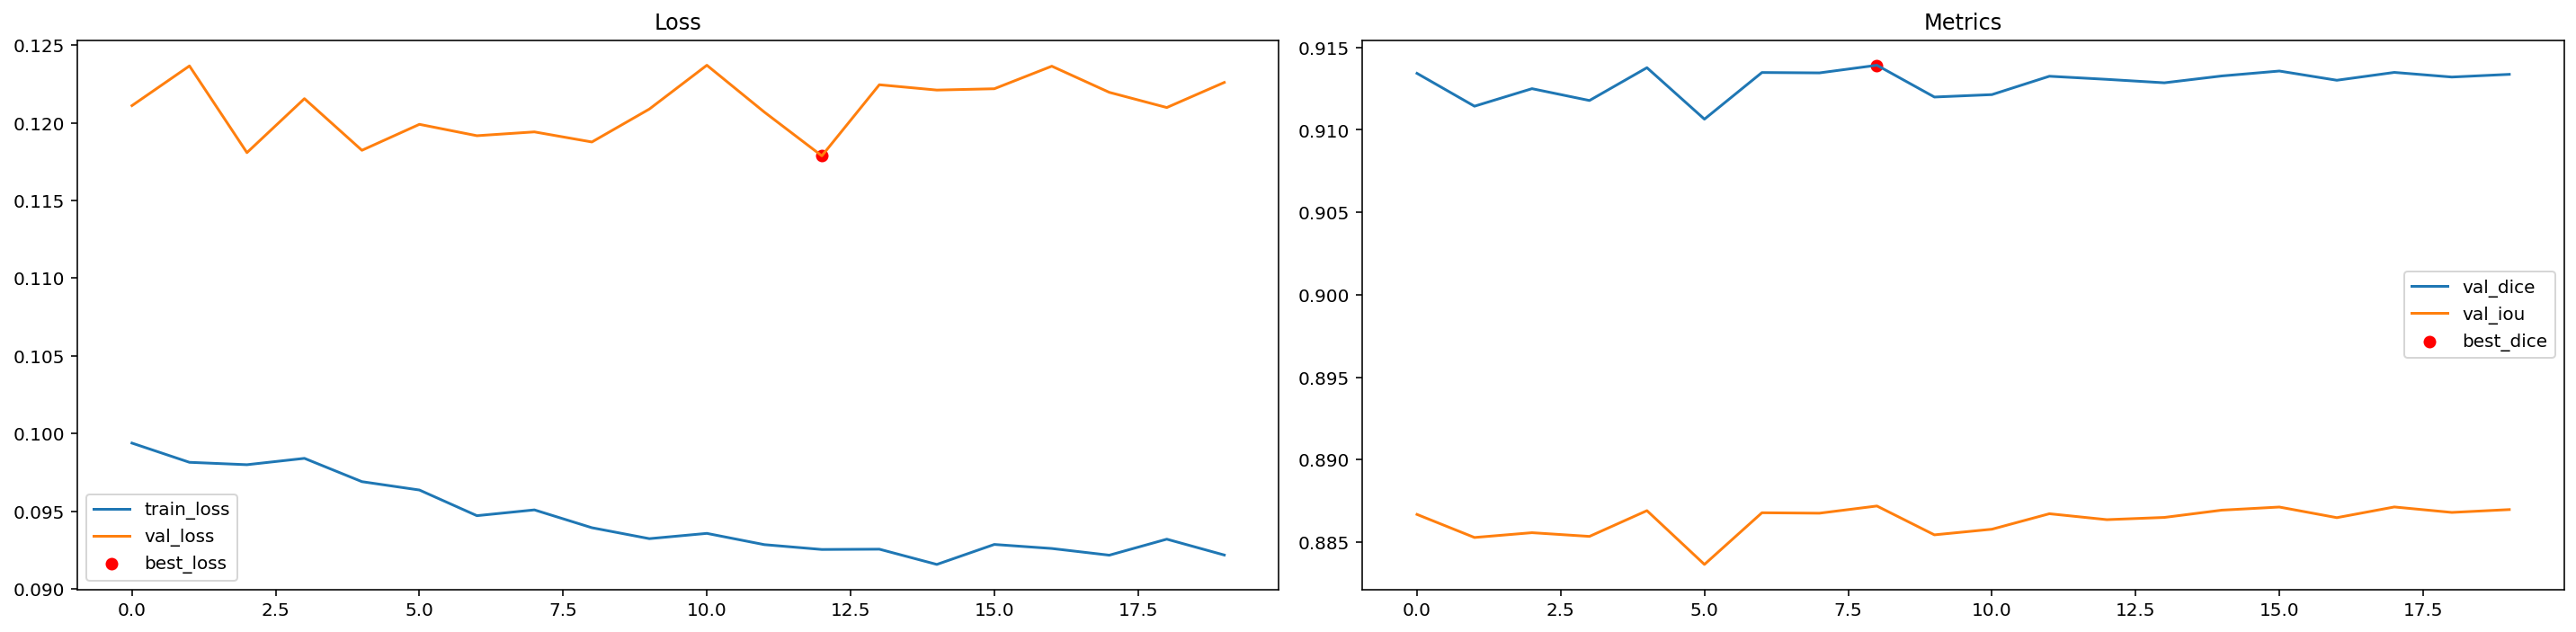

In [19]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.title("Loss")
plt.plot(
    history["train_loss"],
    label="train_loss",
)
plt.plot(history["val_loss"], label="val_loss")
plt.scatter(
    history["best_loss_epoch"], history["best_loss"], color="r", label="best_loss"
)
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Metrics")
plt.plot(history["val_dice"], label="val_dice")
plt.plot(history["val_iou"], label="val_iou")
plt.scatter(
    history["best_dice_epoch"], history["best_dice"], color="r", label="best_dice"
)
plt.legend()
plt.tight_layout()
plt.show();

In [20]:
model.load_state_dict(best_weights["loss"])

<All keys matched successfully>

In [21]:
# model.load_state_dict(best_weights["loss"])

In [22]:
test_ds = Dataset(
    df=df[(df["fold"] == CONFIG["FOLD"]) & (df["is_mask"])],
    img_size=CONFIG["IMG_SIZE"],
    n_img_chanels=CONFIG["N_CHANELS"],
    uint8=CONFIG["UINT8"],
    sequence=CONFIG["SEQUENCE"],
    npy_col="3Dnpy_s1",
    norm=CONFIG["NORMALIZE"],
    shuffle=True,
    seed=CONFIG["SEED"],
    transform=None,
)
test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=CONFIG["BATCH_SIZE"], shuffle=False, num_workers=0
)

In [23]:
imgs, masks = next(iter(test_loader))

In [24]:
predictions = torch.nn.Sigmoid()(model(imgs.to("cuda"))).detach().cpu().numpy()

imgs = imgs.detach().cpu().numpy()
masks = masks.detach().cpu().numpy()

IndexError: index 15 is out of bounds for axis 0 with size 14

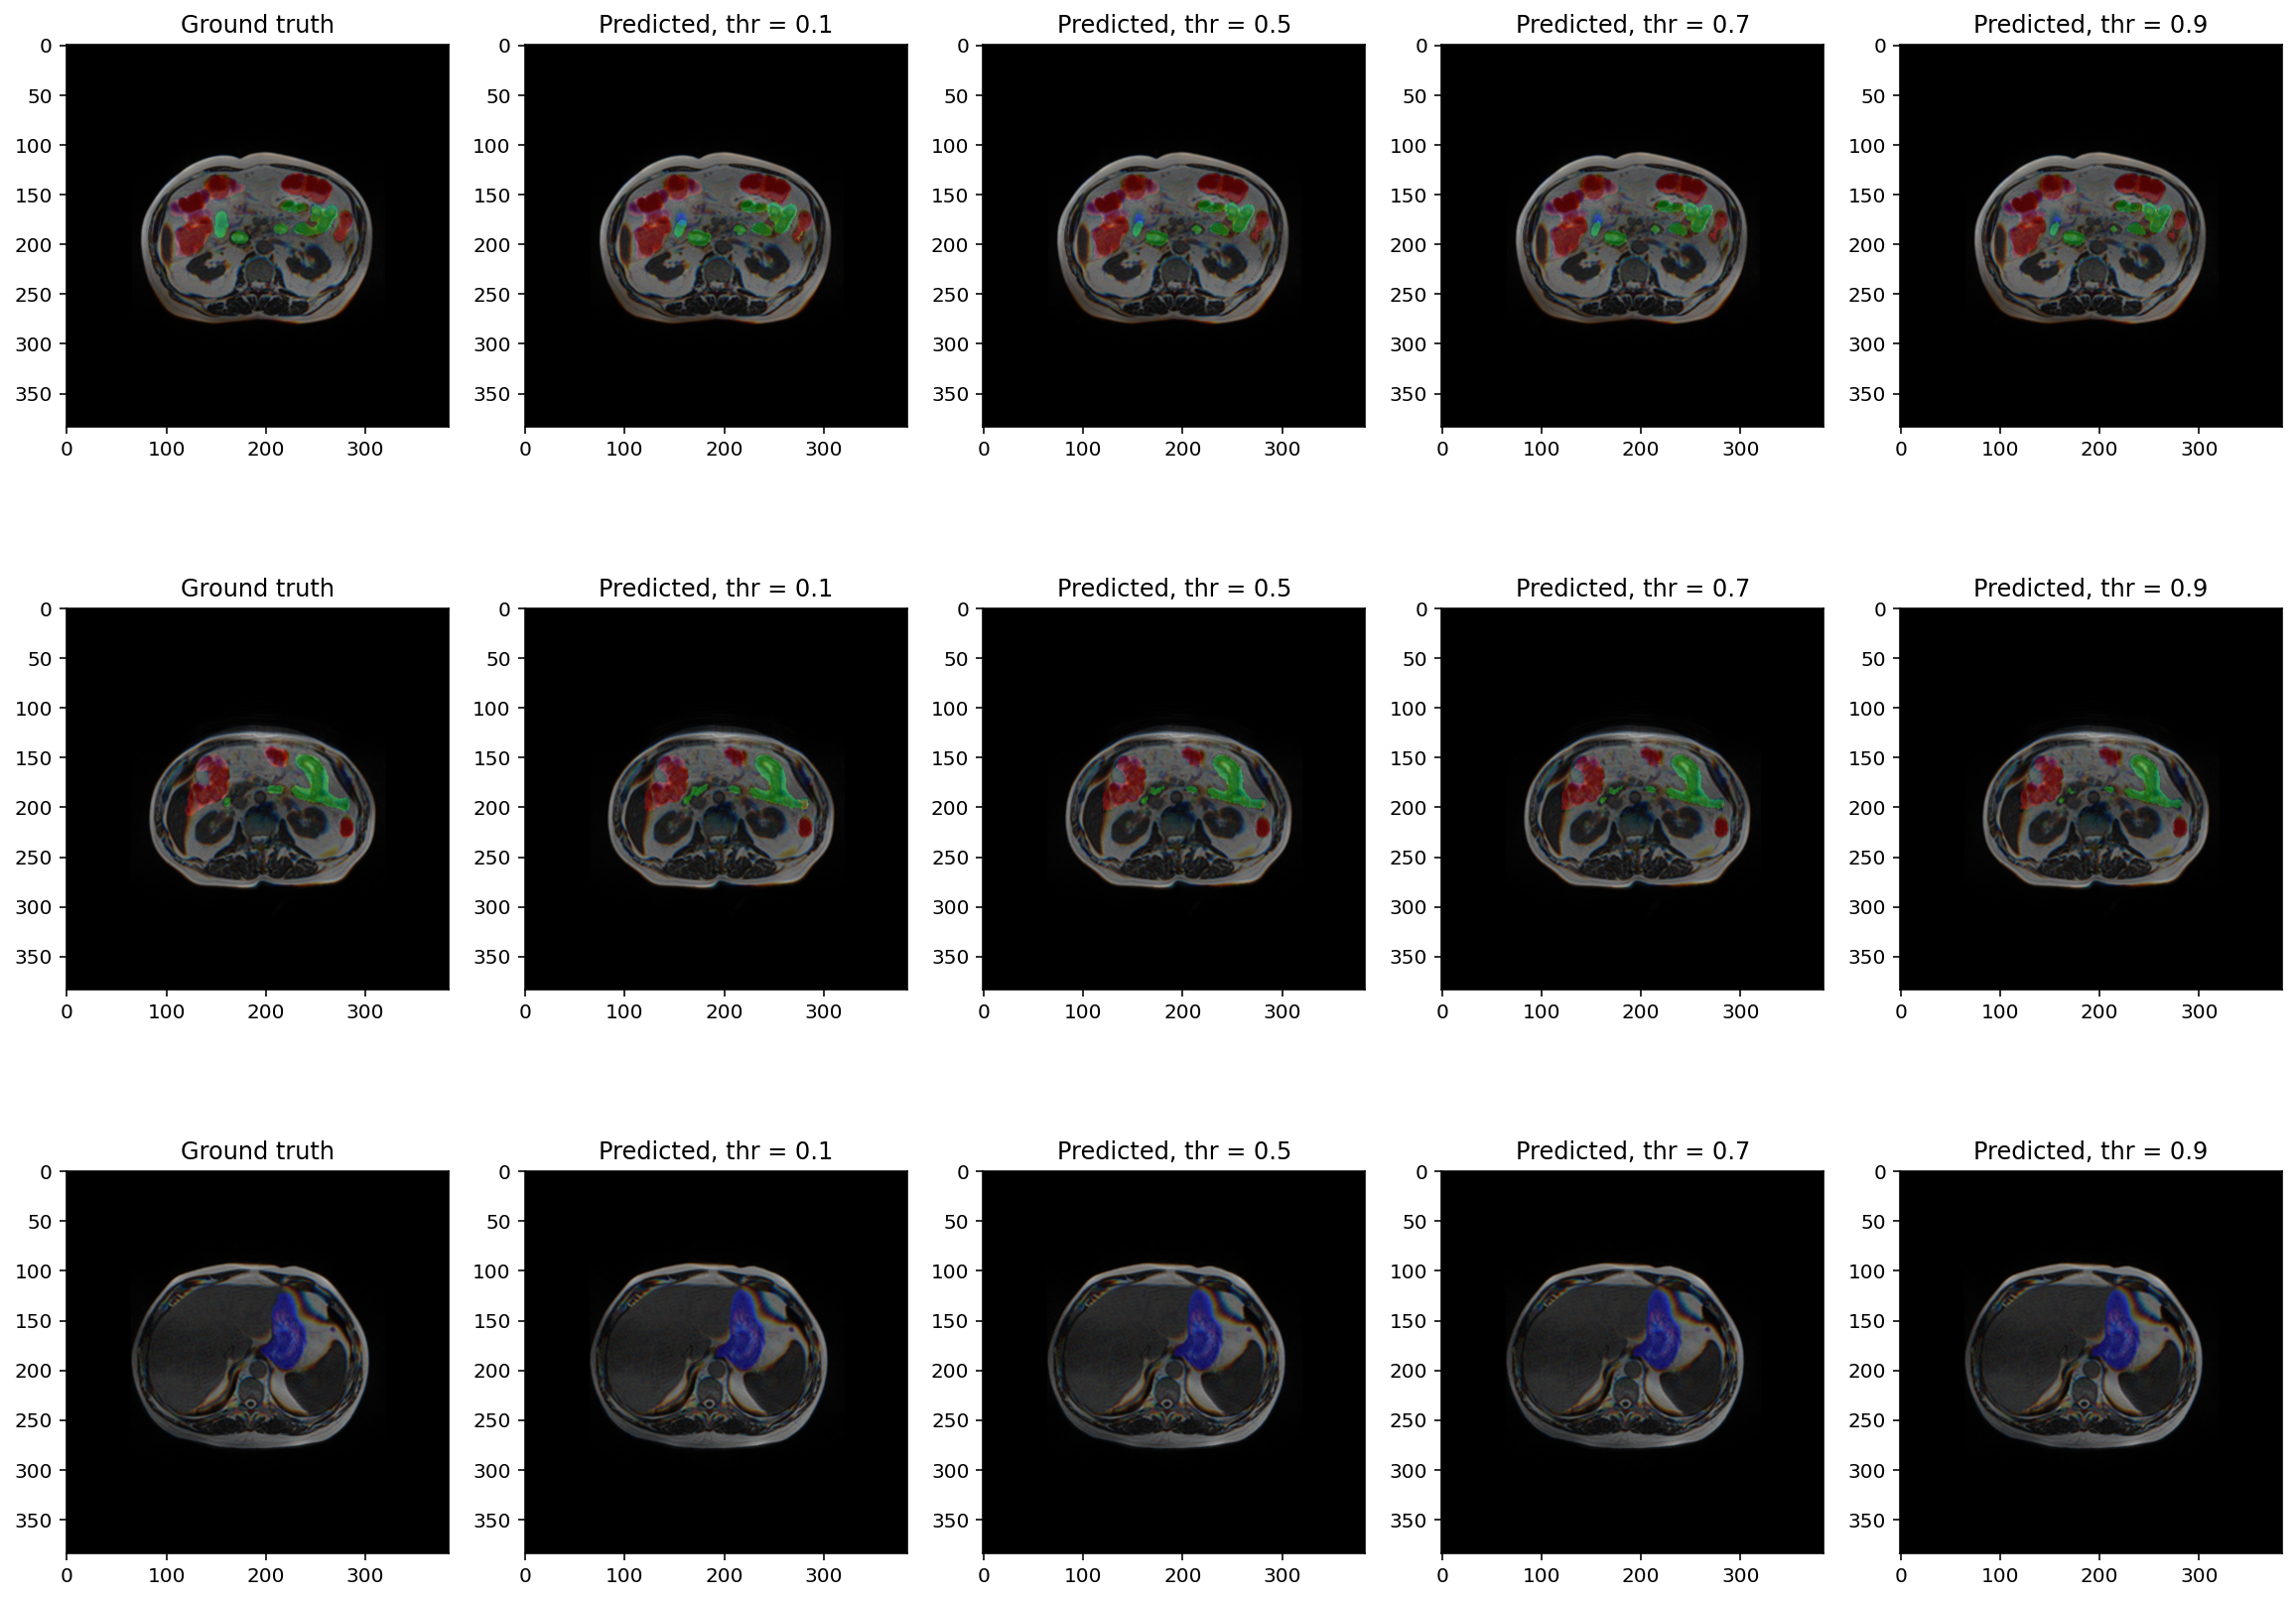

In [25]:
thr = [0.1, 0.5, 0.7, 0.9]

plt.figure(figsize=(20, 20))
for i in range(0, 20, 5):
    pred = predictions[i]
    mask = masks[i]
    img = imgs[i]
    plt.subplot(4, 5, i + 1)
    plt.title("Ground truth")
    plt.imshow(np.moveaxis(img, 0, 2))
    plt.imshow(np.moveaxis(mask.astype("float32"), 0, 2), alpha=0.3)
    plt.subplot(4, 5, i + 2)
    plt.title(f"Predicted, thr = {thr[0]}")
    plt.imshow(np.moveaxis(img, 0, 2))
    plt.imshow(np.moveaxis((pred > thr[0]).astype("float32"), 0, 2), alpha=0.3)
    plt.subplot(4, 5, i + 3)
    plt.title(f"Predicted, thr = {thr[1]}")
    plt.imshow(np.moveaxis(img, 0, 2))
    plt.imshow(np.moveaxis((pred > thr[1]).astype("float32"), 0, 2), alpha=0.3)
    plt.subplot(4, 5, i + 4)
    plt.title(f"Predicted, thr = {thr[2]}")
    plt.imshow(np.moveaxis(img, 0, 2))
    plt.imshow(np.moveaxis((pred > thr[2]).astype("float32"), 0, 2), alpha=0.3)
    plt.subplot(4, 5, i + 5)
    plt.title(f"Predicted, thr = {thr[3]}")
    plt.imshow(np.moveaxis(img, 0, 2))
    plt.imshow(np.moveaxis((pred > thr[3]).astype("float32"), 0, 2), alpha=0.3)
plt.show();

In [7]:
CONFIG["MODEL_PATH"]

'/app/_data/models/deeplab_fold_1_seed_42_v3_seq_mod_0/'

In [8]:
!kaggle datasets init -p {CONFIG["MODEL_PATH"]}

Data package template written to: /app/_data/models/deeplab_fold_1_seed_42_v3_seq_mod_0/dataset-metadata.json


In [9]:
with open(os.path.join(CONFIG["MODEL_PATH"], "dataset-metadata.json"), "r") as f:
    meta = json.load(f)

In [10]:
name = f"deeplab-f{CONFIG['FOLD']}-s{CONFIG['SEED']}-seq1-mod3b0"
meta["title"] = name
meta["id"] = f"nataliayurasova/{name}"

In [11]:
meta

{'title': 'deeplab-f1-s42-seq1-mod3b0',
 'id': 'nataliayurasova/deeplab-f1-s42-seq1-mod3b0',
 'licenses': [{'name': 'CC0-1.0'}]}

In [12]:
with open(os.path.join(CONFIG["MODEL_PATH"], "dataset-metadata.json"), "w") as f:
    json.dump(meta, f)

In [13]:
!kaggle datasets create -p {CONFIG["MODEL_PATH"]} -r zip

Starting upload for file weights.zip
100%|████████████████████████████████████████| 256M/256M [03:21<00:00, 1.33MB/s]
Upload successful: weights.zip (256MB)
Starting upload for file history.json
100%|████████████████████████████████████████| 1.75k/1.75k [00:02<00:00, 777B/s]
Upload successful: history.json (2KB)
Starting upload for file config.json
100%|████████████████████████████████████████████| 421/421 [00:02<00:00, 163B/s]
Upload successful: config.json (421B)
Your private Dataset is being created. Please check progress at https://www.kaggle.com/datasets/nataliayurasova/deeplab-f1-s42-seq1-mod3b0
